# Deep Learning Personal Project: SGA implementation, Comparison and Evaluation

- Code implemented by Sirius See, SDCS, SYSU
- Student Name: Xi Rui
- Student ID: 16340247

## Acknowledgement

- The Symplectic Gradient Adjustment (SGA) algorithm is first introduced in [The Mechanics of n-Player Differentiable Games](http://proceedings.mlr.press/v80/balduzzi18a/balduzzi18a.pdf) by **David Balduzzi** in ICML 2018.
- The code is inspired by **Deep Mind**'s [SGA algorithm](https://github.com/deepmind/symplectic-gradient-adjustment) in 2018.

- The  Optimistic Mirror Descent (OMD) is first introduced in [Optimistic mirror descent in saddle-point problems: Going the extra (gradient) mile](https://arxiv.org/pdf/1807.02629.pdf) by **Panayotis Mertikopoulos** in ICLR 2019
- **A series of experiments is added by Sirius See (Xi Rui)** as the **solo project of Deep Learning course** in Sun Yat-sen University. Further detailed description of my work will be listed in the following section.
- **Google Colab**  and **SYSU InPlusLab** provide the devices (mainly GPUs) for me to conduct the following experiments.




## Table of Content
0. Tensorflow Environment Preparation
1. Experiment 1: Symplectic Gradient Adjustment (SGA) algorithm implementation
2. Experiment 2: Basic multilayer perceptron (MLP) model implementation
3. Experiment 3: Generative Adversarial Network (GAN) implementation
4. Experiment 4: Comparison of optimizers when learning a 4 by 4 mixture of Gaussian in 2D
  1. Using Stochastic Gradient Descent (SGD)
  2. Using AdaGrad
  3. Using RMSProp
  4. Using Adam
  5. Using SGA
5. Experiment 5: Optimistic Mirror Descent (OMD) algorithm implementation
4. Experiment 6: Comparison of learning rate threshold of OMD and SGA in Gaussian mixture model
  1. Using OMD
  2. Using SGA
5. Experiment 7: Comparison of optimizers when learning a high dimensional Gaussian
  1. Using RMSProp
  2. Using SGA
5. Experiment 8: An SGA implementation in PyTorch

## Tensorflow Environment Preparation



In [4]:
!pip install dm-sonnet
!pip install 'kfac[tensorflow]' 

     |████████████████████████████████| 143kB 4.6MB/s 


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
import numpy as np
import sonnet as snt
import tensorflow as tf 
import kfac

import matplotlib.pyplot as plt
import scipy as sp

W0711 01:50:12.525845 140060646823808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/kfac/python/ops/optimizer.py:47: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.

W0711 01:50:12.527219 140060646823808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/kfac/python/ops/optimizer.py:399: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Experiment 1: Symplectic Gradient Adjustment (SGA) algorithm implementation

In [0]:
# help function of SymplecticOptimizer

def list_divide_scalar(xs, y):
  return [x / y for x in xs]


def list_subtract(xs, ys):
  return [x - y for (x, y) in zip(xs, ys)]


def jacobian_vec(ys, xs, vs):
  return kfac.utils.fwd_gradients(
      ys, xs, grad_xs=vs, stop_gradients=xs)


def jacobian_transpose_vec(ys, xs, vs):
  dydxs = tf.gradients(ys, xs, grad_ys=vs, stop_gradients=xs)
  dydxs = [
      tf.zeros_like(x) if dydx is None else dydx for x, dydx in zip(xs, dydxs)
  ]
  return dydxs


def _dot(x, y):
  dot_list = []
  for xx, yy in zip(x, y):
    dot_list.append(tf.reduce_sum(xx * yy))
  return tf.add_n(dot_list)

In [0]:
#@title Default title text
# impl of SGA optimizer

class SymplecticOptimizer(tf.train.Optimizer):
  """Optimizer that corrects for rotational components in gradients."""

  def __init__(self,
               learning_rate,
               reg_params=1.,
               use_signs=True,
               use_locking=False,
               name='symplectic_optimizer'):
    super(SymplecticOptimizer, self).__init__(
        use_locking=use_locking, name=name)
    self._gd = tf.train.RMSPropOptimizer(learning_rate)
    self._reg_params = reg_params
    self._use_signs = use_signs

  def compute_gradients(self,
                        loss,
                        var_list=None,
                        gate_gradients=tf.train.Optimizer.GATE_OP,
                        aggregation_method=None,
                        colocate_gradients_with_ops=False,
                        grad_loss=None):
    return self._gd.compute_gradients(loss, var_list, gate_gradients,
                                      aggregation_method,
                                      colocate_gradients_with_ops, grad_loss)

  def apply_gradients(self, grads_and_vars, global_step=None, name=None):
    grads, vars_ = zip(*grads_and_vars)
    n = len(vars_)
    h_v = jacobian_vec(grads, vars_, grads)
    ht_v = jacobian_transpose_vec(grads, vars_, grads)
    at_v = list_divide_scalar(list_subtract(ht_v, h_v), 2.)
    if self._use_signs:
      grad_dot_h = _dot(grads, ht_v)
      at_v_dot_h = _dot(at_v, ht_v)
      mult = grad_dot_h * at_v_dot_h
      lambda_ = tf.sign(mult / n + 0.1) * self._reg_params
    else:
      lambda_ = self._reg_params
    apply_vec = [(g + lambda_ * ag, x)
                 for (g, ag, x) in zip(grads, at_v, vars_)
                 if at_v is not None]
    return self._gd.apply_gradients(apply_vec, global_step, name)


## Experiment 2: Basic multilayer perceptron (MLP) model implementation


In [0]:
class MLP(snt.AbstractModule):

  def __init__(self, depth, hidden_size, out_dim, name='SimpleNet'):
    super(MLP, self).__init__(name=name)
    self._depth = depth
    self._hidden_size = hidden_size
    self._out_dim = out_dim

  def _build(self, input):
    h = input
    for i in range(self._depth):
      h = tf.nn.relu(snt.Linear(self._hidden_size)(h))
    return snt.Linear(self._out_dim)(h)


In [0]:
def reset_and_build_graph(depth, width, x_real_builder, z_dim, batch_size, learning_rate, mode):
  tf.reset_default_graph()

  x_real = x_real_builder(batch_size)
  x_dim = x_real.get_shape().as_list()[1]
  generator = MLP(depth, width, x_dim, 'generator')
  discriminator = MLP(depth, width, 1, 'discriminator')
  z = tf.random_normal([batch_size, z_dim])
  x_fake = generator(z)
  disc_out_real = discriminator(x_real)
  disc_out_fake = discriminator(x_fake)

  # Loss
  disc_loss_real = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_real, labels=tf.ones_like(disc_out_real)))
  disc_loss_fake = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.zeros_like(disc_out_fake)))
  disc_loss = disc_loss_real + disc_loss_fake

  gen_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.ones_like(disc_out_fake)))
  gen_vars = generator.variable_scope.trainable_variables()
  disc_vars = discriminator.variable_scope.trainable_variables()
  # Compute gradients
  xs = disc_vars + gen_vars
  disc_grads = tf.gradients(disc_loss, disc_vars)
  gen_grads = tf.gradients(gen_loss, gen_vars)
  Xi = disc_grads + gen_grads
  apply_vec = list(zip(Xi, xs))

  if mode == 'RMS':
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
  elif mode == 'SGD':
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  elif mode == 'ADG':
    optimizer = tf.train.AdagradOptimizer(learning_rate)
  elif mode == 'ADA':
    optimizer = tf.train.AdamOptimizer(learning_rate)
  elif mode == 'SGA':
    optimizer = SymplecticOptimizer(learning_rate)
  else:
    raise ValueError('Mode %s not recognised' % mode)

  with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec)

  init = tf.global_variables_initializer()
  
  return train_op, x_fake, z, init, disc_loss, gen_loss


In [0]:
# visualization

def kde(mu, tau, bbox=None, xlabel="", ylabel="", cmap='Blues'):
    values = np.vstack([mu, tau])
    kernel = sp.stats.gaussian_kde(values)

    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    xx, yy = np.mgrid[bbox[0]:bbox[1]:300j, bbox[2]:bbox[3]:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)
    plt.show()

## Experiment 4: Comparison of optimizers when learning a 4 by 4 mixture of Gaussian in 2D

In [0]:
def train(train_op, x_fake, z, init, disc_loss, gen_loss, z_dim,
          n_iter=10001, n_save=2000):
  bbox = [-2, 2, -2, 2]
  batch_size = x_fake.get_shape()[0].value
  ztest = [np.random.randn(batch_size, z_dim) for i in range(10)]

  with tf.Session() as sess:
    sess.run(init)

    for i in range(n_iter):
      disc_loss_out, gen_loss_out, _ = sess.run(
          [disc_loss, gen_loss, train_op])
      if i % n_save == 0:
        print('i = %d, discriminant loss = %.4f, generator loss =%.4f' %
              (i, disc_loss_out, gen_loss_out))
        x_out = np.concatenate(
            [sess.run(x_fake, feed_dict={z: zt}) for zt in ztest], axis=0)
        kde(x_out[:, 0], x_out[:, 1], bbox=bbox)
    
def learn_mixture_of_gaussians(mode):
  print(mode)
  def x_real_builder(batch_size):
    sigma = 0.1
    skel = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    temp = np.tile(skel, (batch_size // 16 + 1,1))
    mus = temp[0:batch_size,:]
    return mus + sigma*tf.random_normal([batch_size, 2])*.2
  
  z_dim = 64
  train_op, x_fake, z, init, disc_loss, gen_loss = reset_and_build_graph(
      depth=6, width=384, x_real_builder=x_real_builder, z_dim=z_dim,
      batch_size=256, learning_rate=1e-4, mode=mode)

  train(train_op, x_fake, z, init, disc_loss, gen_loss, z_dim)


### Using SGD

SGD
i = 0, discriminant loss = 1.4003, generator loss =0.6933


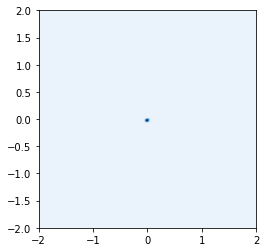

i = 2000, discriminant loss = 1.2123, generator loss =0.6958


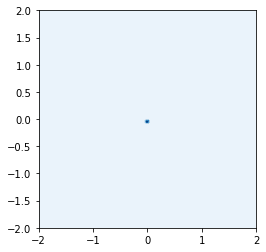

i = 4000, discriminant loss = 1.0371, generator loss =0.6724


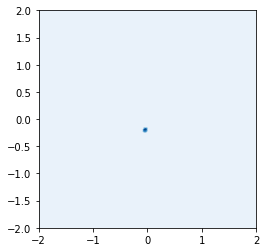

i = 6000, discriminant loss = 1.0122, generator loss =0.6308


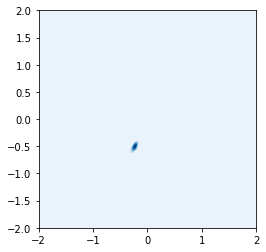

i = 8000, discriminant loss = 0.9194, generator loss =0.7399


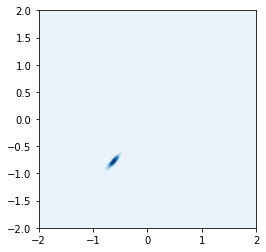

i = 10000, discriminant loss = 0.9195, generator loss =0.8402


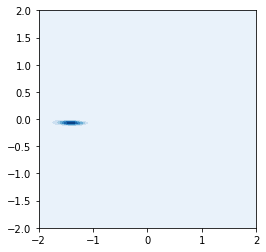

In [0]:
learn_mixture_of_gaussians('SGD')

### Using AdaGrad

ADG


W0710 13:55:39.310465 140150887180160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


i = 0, discriminant loss = 1.3714, generator loss =0.6926


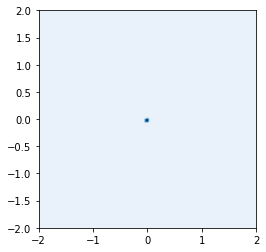

i = 2000, discriminant loss = 1.0970, generator loss =0.6096


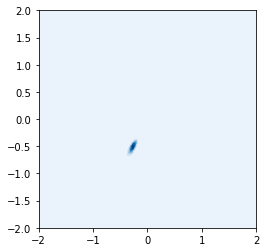

i = 4000, discriminant loss = 0.9673, generator loss =0.6934


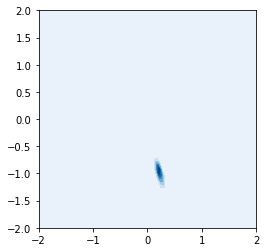

i = 6000, discriminant loss = 1.1352, generator loss =0.8187


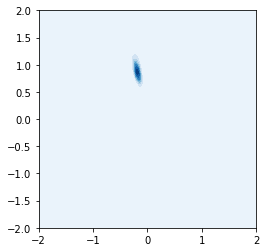

i = 8000, discriminant loss = 1.0060, generator loss =0.7855


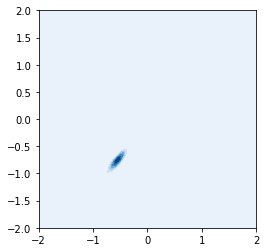

i = 10000, discriminant loss = 0.9412, generator loss =0.8080


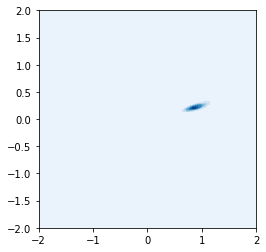

In [0]:
learn_mixture_of_gaussians('ADG')

### Using Adam

ADA
i = 0, discriminant loss = 1.3380, generator loss =0.6903


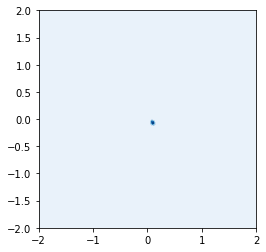

i = 2000, discriminant loss = 1.1390, generator loss =0.8283


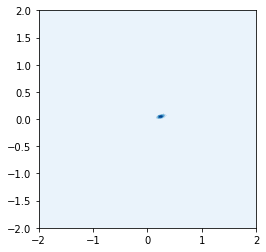

i = 4000, discriminant loss = 0.8575, generator loss =1.1069


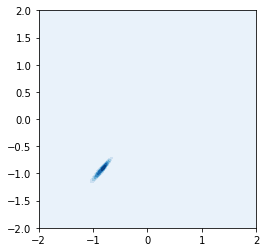

i = 6000, discriminant loss = 1.4832, generator loss =0.9082


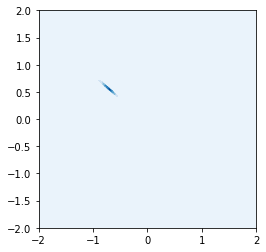

i = 8000, discriminant loss = 1.3655, generator loss =0.9416


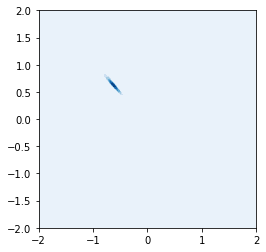

i = 10000, discriminant loss = 0.7635, generator loss =0.9369


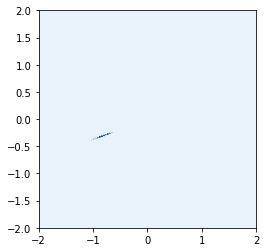

In [0]:
learn_mixture_of_gaussians('ADA')

### Using RMSProp


W0710 11:44:01.528981 140150887180160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/modules/base.py:177: The name tf.make_template is deprecated. Please use tf.compat.v1.make_template instead.

W0710 11:44:01.554638 140150887180160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/modules/base.py:278: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 11:44:01.561922 140150887180160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/sonnet/python/modules/basic.py:126: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0710 11:44:01.562939 140150887180160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/sonnet/python/modules/basic.p

RMS


W0710 11:44:01.825356 140150887180160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0710 11:44:02.175057 140150887180160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


i = 0, discriminant loss = 1.4136, generator loss =0.6941


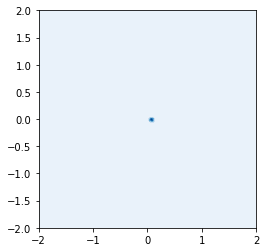

i = 2000, discriminant loss = 1.0527, generator loss =1.5996


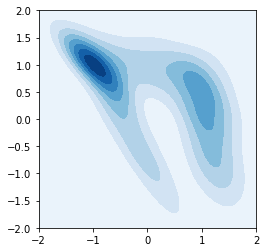

i = 4000, discriminant loss = 0.4317, generator loss =2.0905


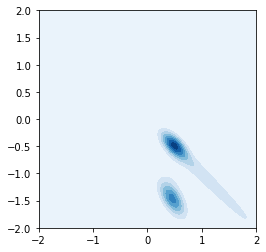

i = 6000, discriminant loss = 0.4968, generator loss =2.1840


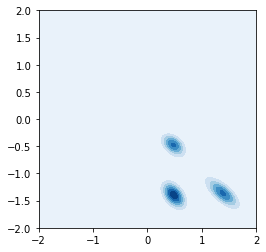

i = 8000, discriminant loss = 0.4876, generator loss =1.7091


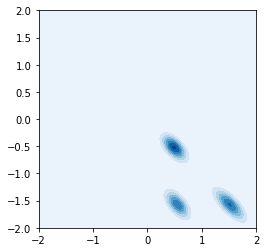

i = 10000, discriminant loss = 0.5137, generator loss =1.7146


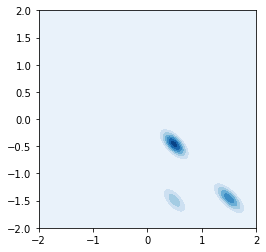

In [0]:
learn_mixture_of_gaussians('RMS')


SGA
i = 0, discriminant loss = 1.4156, generator loss =0.6938


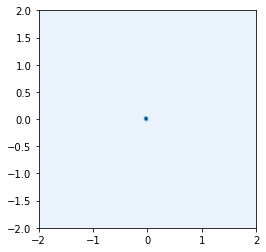

i = 2000, discriminant loss = 1.3443, generator loss =0.7208


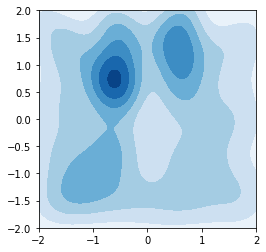

i = 4000, discriminant loss = 1.3732, generator loss =0.7006


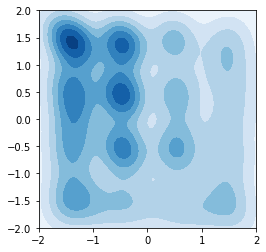

i = 6000, discriminant loss = 1.3827, generator loss =0.6935


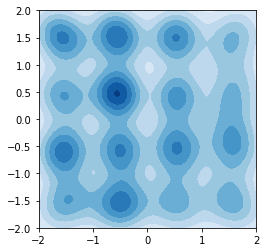

i = 8000, discriminant loss = 1.3852, generator loss =0.6940


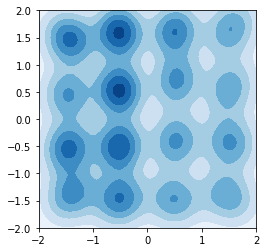

i = 10000, discriminant loss = 1.3853, generator loss =0.6939


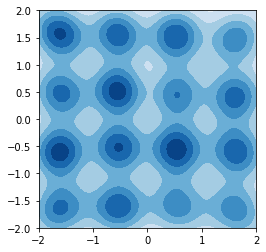

In [0]:
# Use Symplectic Gradient Adjustment to optimise the GAN parameters.
# With SGA, all modes are produced by the trained GAN.
learn_mixture_of_gaussians('SGA')


## Experiment 5: Optimistic Mirror Descent (OMD) algorithm implementation


In [0]:
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer


class AdamirrorOptimizer(optimizer.Optimizer):


  def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8,
               use_locking=False, name="Adamirror"):

    
    super(AdamirrorOptimizer, self).__init__(use_locking, name)
    self._lr = learning_rate
    self._beta1 = beta1
    self._beta2 = beta2

    self._lr_t = None
    self._beta1_t = None
    self._beta2_t = None
    self._t = None

  def _prepare(self):
    self._lr_t = ops.convert_to_tensor(self._lr, name="learning_rate")
    self._beta1_t = ops.convert_to_tensor(self._beta1, name="beta1")
    self._beta2_t = ops.convert_to_tensor(self._beta2, name="beta2")
    self._t = ops.convert_to_tensor(0, name="t")


  def _create_slots(self, var_list):
    for v in var_list:
      self._zeros_slot(v, "m", self._name)
      self._zeros_slot(v, "v", self._name)
      self._zeros_slot(v, "g", self._name)
      
  def _apply_dense(self, grad, var):
    lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
    beta1_t = math_ops.cast(self._beta1_t, var.dtype.base_dtype)
    beta2_t = math_ops.cast(self._beta2_t, var.dtype.base_dtype)
    if var.dtype.base_dtype == tf.float16:
        eps = 1e-7
    else:
        eps = 1e-8
    t = self._t
    
    t = t+1
    v = self.get_slot(var, "v")
    v_t = v.assign(beta2_t * v + (1. - beta2_t) * tf.square(grad))
    m = self.get_slot(var, "m")
    m_t = m.assign( beta1_t * m + (1. - beta1_t) * grad )
    v_t_hat = tf.div(v_t, 1. - tf.pow(beta2_t, t))
    m_t_hat = tf.div(m_t, 1. - tf.pow(beta1_t, t))
    
    g_t = tf.div( m_t_hat, tf.sqrt(v_t_hat)+eps )
    g_t_1 = self.get_slot(var, "g")
    g_t = g_t_1.assign( g_t )
    
    t_t = self._t.assign(t)

    var_update = state_ops.assign_sub(var, 2. * lr_t * g_t - lr_t * g_t_1) #Adam would be lr_t * g_t
    return control_flow_ops.group(*[var_update, m_t, v_t, g_t, t_t])
  
  def _apply_sparse(self, grad, var):
    raise NotImplementedError("Sparse gradient updates are not supported.")

In [0]:
x = tf.constant([[2, 2.0], [3, 3]])
y = tf.constant([[8, 16], [2, 3]])
print(tf.pow(x, y))  # [[256, 65536], [9, 27]]

TypeError: ignored

## Experiment 6: Comparison of learning rate threshold of OMD and SGA in Gaussian mixture model


In [0]:
def reset_and_build_graph_with_lr(depth, width, x_real_builder, z_dim, batch_size, learning_rate, mode):
  tf.reset_default_graph()

  x_real = x_real_builder(batch_size)
  x_dim = x_real.get_shape().as_list()[1]
  generator = MLP(depth, width, x_dim, 'generator')
  discriminator = MLP(depth, width, 1, 'discriminator')
  z = tf.random_normal([batch_size, z_dim])
  x_fake = generator(z)
  disc_out_real = discriminator(x_real)
  disc_out_fake = discriminator(x_fake)

  # Loss
  disc_loss_real = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_real, labels=tf.ones_like(disc_out_real)))
  disc_loss_fake = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.zeros_like(disc_out_fake)))
  disc_loss = disc_loss_real + disc_loss_fake

  gen_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.ones_like(disc_out_fake)))
  gen_vars = generator.variable_scope.trainable_variables()
  disc_vars = discriminator.variable_scope.trainable_variables()
  # Compute gradients
  xs = disc_vars + gen_vars
  disc_grads = tf.gradients(disc_loss, disc_vars)
  gen_grads = tf.gradients(gen_loss, gen_vars)
  Xi = disc_grads + gen_grads
  apply_vec = list(zip(Xi, xs))

  if mode == 'RMS':
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
  elif mode == 'OMD':
    optimizer = AdamirrorOptimizer(learning_rate)
  elif mode == 'SGA':
    optimizer = SymplecticOptimizer(learning_rate)
  else:
    raise ValueError('Mode %s not recognised' % mode)

  with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec)

  init = tf.global_variables_initializer()
  
  return train_op, x_fake, z, init, disc_loss, gen_loss

In [0]:
def learn_mixture_of_gaussians_with_lr(mode, learning_rate):
  print(mode)
  def x_real_builder(batch_size):
    sigma = 0.1
    skel = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    temp = np.tile(skel, (batch_size // 16 + 1,1))
    mus = temp[0:batch_size,:]
    return mus + sigma*tf.random_normal([batch_size, 2])*.2
  
  z_dim = 64
  train_op, x_fake, z, init, disc_loss, gen_loss = reset_and_build_graph_with_lr(
      depth=6, width=384, x_real_builder=x_real_builder, z_dim=z_dim,
      batch_size=256, learning_rate=learning_rate, mode=mode)

  train(train_op, x_fake, z, init, disc_loss, gen_loss, z_dim)

In [0]:
lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

### Using OMD

In [22]:
for lr in lrs:
  learn_mixture_of_gaussians_with_lr('OMD', lr)

OMD


NameError: ignored

### Using SGA

SGA
i = 0, discriminant loss = 1.3660, generator loss =0.6924


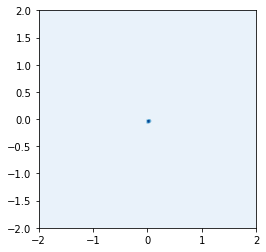

i = 2000, discriminant loss = 0.9693, generator loss =0.7837


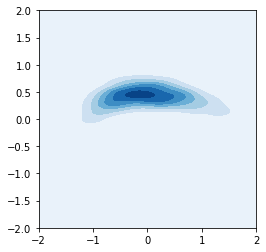

i = 4000, discriminant loss = 5.6121, generator loss =0.0429


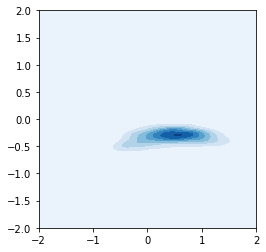

i = 6000, discriminant loss = 5.6527, generator loss =0.3095


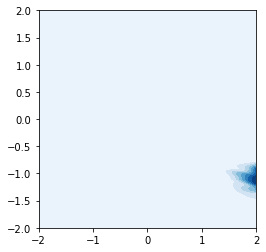

i = 8000, discriminant loss = 49.1593, generator loss =1.2838


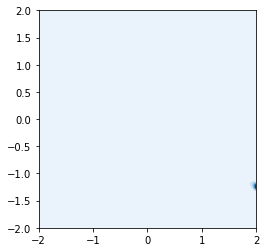

i = 10000, discriminant loss = 294.4630, generator loss =12.8131


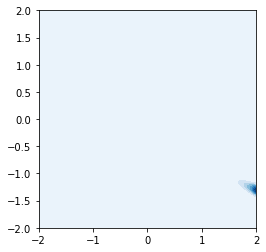

SGA
i = 0, discriminant loss = 1.3483, generator loss =0.6920


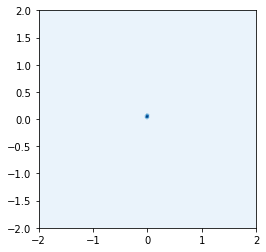

i = 2000, discriminant loss = 0.8996, generator loss =0.7104


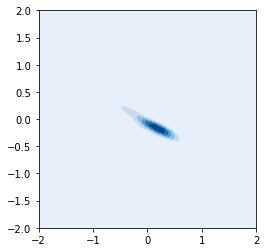

i = 4000, discriminant loss = 0.6597, generator loss =1.3435


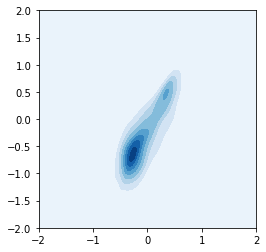

i = 6000, discriminant loss = 1.1008, generator loss =0.9895


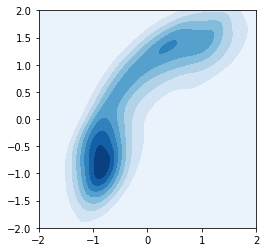

i = 8000, discriminant loss = 0.9388, generator loss =1.0736


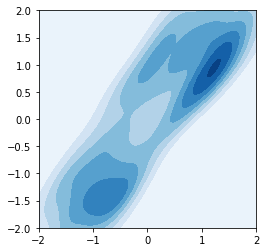

i = 10000, discriminant loss = 0.9927, generator loss =1.1249


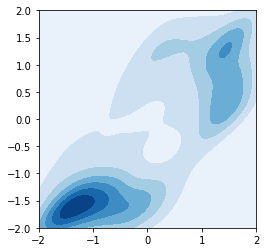

SGA
i = 0, discriminant loss = 1.3930, generator loss =0.6940


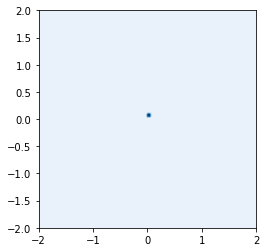

i = 2000, discriminant loss = 1.3426, generator loss =0.7182


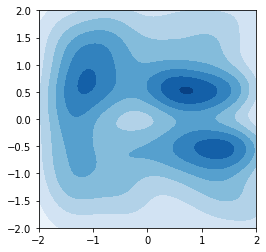

i = 4000, discriminant loss = 1.3656, generator loss =0.7059


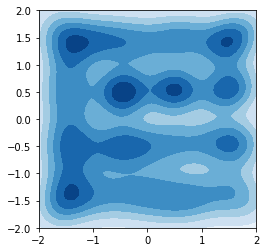

i = 6000, discriminant loss = 1.3823, generator loss =0.6944


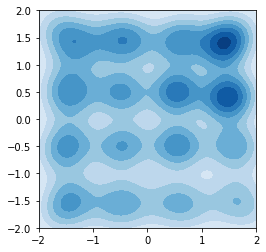

i = 8000, discriminant loss = 1.3850, generator loss =0.6939


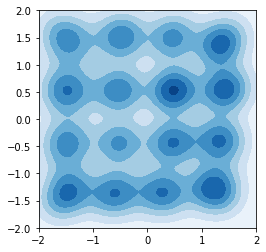

i = 10000, discriminant loss = 1.3854, generator loss =0.6939


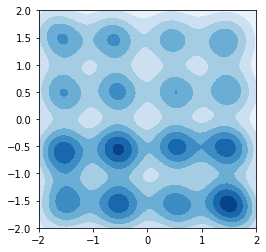

SGA
i = 0, discriminant loss = 1.3845, generator loss =0.6932


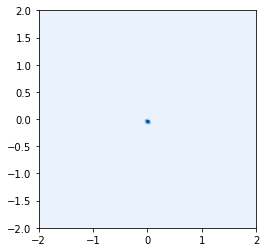

i = 2000, discriminant loss = 0.2664, generator loss =1.9103


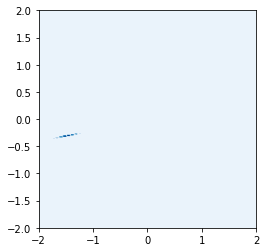

i = 4000, discriminant loss = 0.1573, generator loss =2.3711


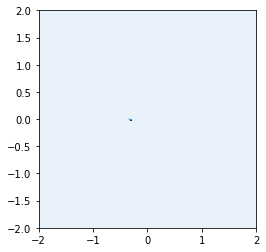

i = 6000, discriminant loss = 0.1241, generator loss =2.2053


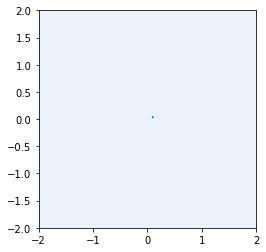

i = 8000, discriminant loss = 0.0150, generator loss =4.2232


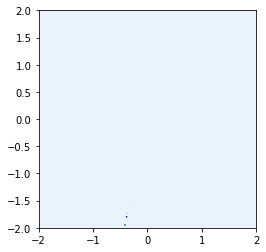

i = 10000, discriminant loss = 0.0006, generator loss =7.6488


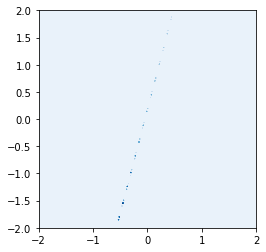

SGA
i = 0, discriminant loss = 1.3746, generator loss =0.6926


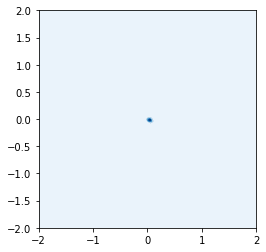

i = 2000, discriminant loss = 0.1350, generator loss =2.0975


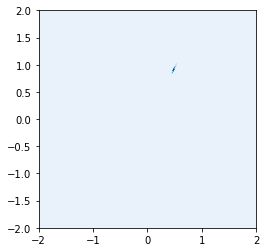

i = 4000, discriminant loss = 0.0353, generator loss =3.3729


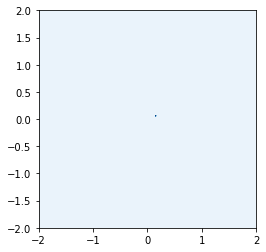

i = 6000, discriminant loss = 0.4416, generator loss =2.4975


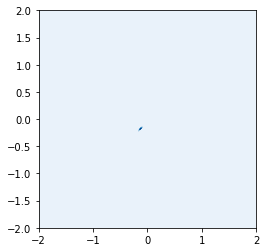

In [0]:
for lr in lrs:
  learn_mixture_of_gaussians_with_lr('SGA', lr)

## Experiment 7: Comparison of optimizers when learning a high dimensional Gaussian

Learning a high dimensional Gaussian (dimension 75 in the experiment below) using a GAN is an experiment that was proposed in [A Classification–Based Study of Covariate Shift in GAN Distributions](https://arxiv.org/pdf/1711.00970.pdf) by Santurkar in ICML 2018 .

In the experiments below, the graphs plot all 75 singular values, in decreasing order, of the covariance matrix of the data generated by the GAN.

In [0]:
def compute_eigenvalue(sess, x, n_pts, title):
  """Computes the singular values of the covariance matrix of x.
  
  The singular values are displayed in decreasing order in a plot.
  
  Args:
    sess: a Session object.
    x: a Tensor of shape ```(batch_size, x_dim)```
    n_pts: an int; the number of points used to compute the covariance matrix
    title: a string; the title of the displayed plot
  """
  batch_size, x_dim = x.get_shape().as_list()
  # Round n_pts to the next multiple of batch_size
  n_runs = (n_pts + batch_size - 1) // batch_size
  n_pts = n_runs * batch_size
  mean = np.zeros([x_dim])
  moment = np.zeros([x_dim, x_dim])
  for _ in range(n_runs):
    x_out = sess.run(x)
    mean += np.sum(x_out, axis=0)
    moment += np.matmul(x_out.transpose(), x_out)
  mean /= n_pts
  moment /= n_pts
  mean_2 = np.expand_dims(mean, 0)
  cov = moment - np.matmul(mean_2.transpose(), mean_2)
  u, s, vh = np.linalg.svd(cov)
  plt.plot(s)
  plt.title(title)
  plt.show()


def train(train_op, x_fake, init, disc_loss, gen_loss):
  n_iter = 20001
  n_save = 2000

  with tf.Session() as sess:
    sess.run(init)

    compute_eigenvalue(sess, x_fake, 2**20, 'BEFORE TRAINING')

    for i in range(n_iter):
      sess.run(train_op)
      disc_loss_out, gen_loss_out = sess.run([disc_loss, gen_loss])
      if i % n_save == 0:
        print('i = %d, discriminant loss = %.4f, generator loss =%.4f' %
              (i, disc_loss_out, gen_loss_out))
        compute_eigenvalue(sess, x_fake, 2**15, 'iter %d' % i)

    compute_eigenvalue(sess, x_fake, 2**20, 'AFTER TRAINING')


def high_dim_gaussian_experiment(mode):
  print(mode)

  x_dim = 75
  def x_real_builder(batch_size):
    return tf.random_normal([batch_size, x_dim])

  train_op, x_fake, unused_z, init, disc_loss, gen_loss = reset_and_build_graph(
      depth=2, width=200, x_real_builder=x_real_builder, z_dim=200,
      batch_size=64, learning_rate=2e-4, mode=mode)

  train(train_op, x_fake, init, disc_loss, gen_loss)


### Using RMS

RMS


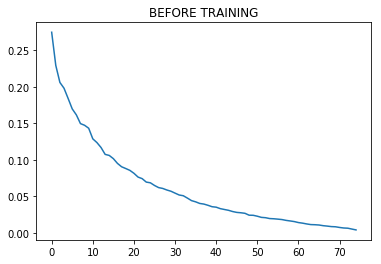

i = 0, discriminant loss = 1.3822, generator loss =0.6249


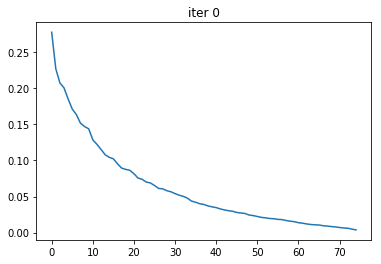

i = 2000, discriminant loss = 1.4030, generator loss =0.6816


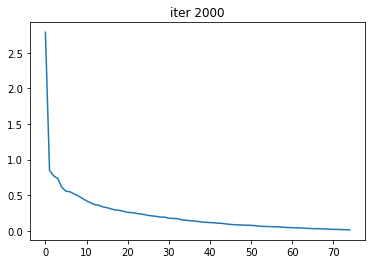

i = 4000, discriminant loss = 1.4097, generator loss =0.6523


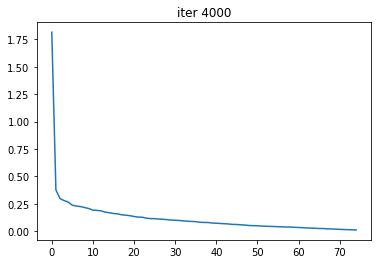

i = 6000, discriminant loss = 1.4174, generator loss =0.6912


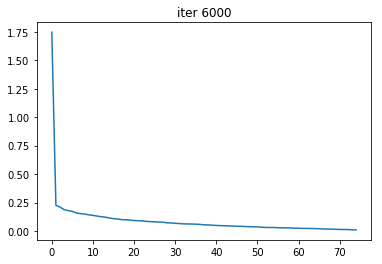

i = 8000, discriminant loss = 1.4118, generator loss =0.6706


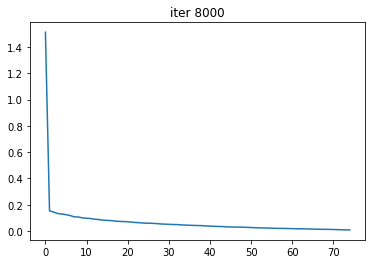

i = 10000, discriminant loss = 1.3706, generator loss =0.7215


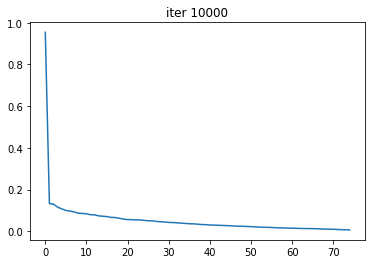

i = 12000, discriminant loss = 1.3736, generator loss =0.7113


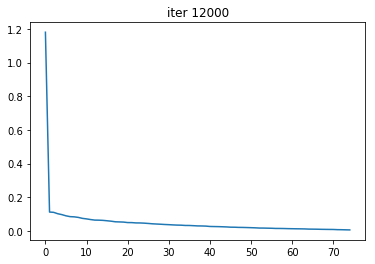

i = 14000, discriminant loss = 1.3803, generator loss =0.7034


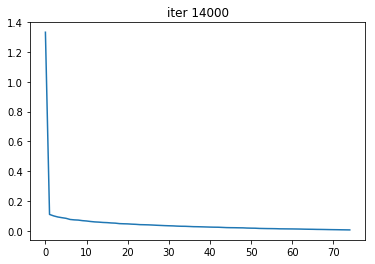

i = 16000, discriminant loss = 1.4275, generator loss =0.7320


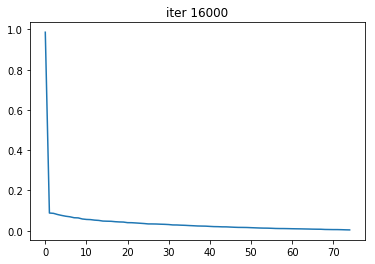

i = 18000, discriminant loss = 1.3801, generator loss =0.6883


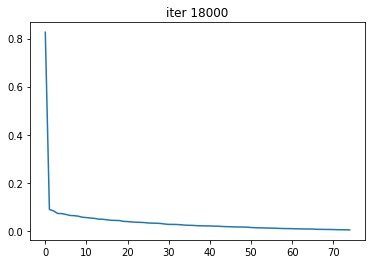

i = 20000, discriminant loss = 1.4164, generator loss =0.7083


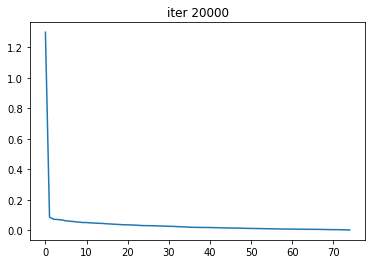

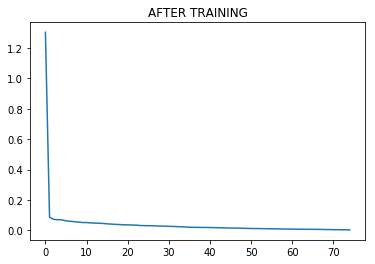

In [14]:
# Use plain RmsProp to optimise the GAN parameters.
# This experiment demonstrate how traditional GAN training fails to learn all
# the directions of a high dimensional Gaussian.
high_dim_gaussian_experiment('RMS')


### Using SGA

SGA


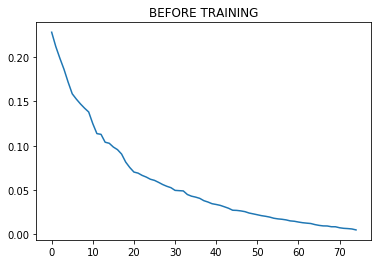

i = 0, discriminant loss = 1.5273, generator loss =0.7279


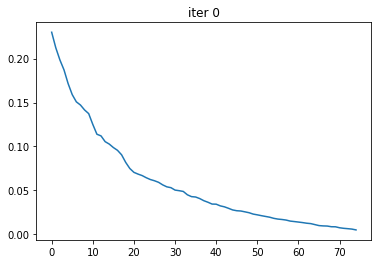

i = 2000, discriminant loss = 1.2478, generator loss =0.7696


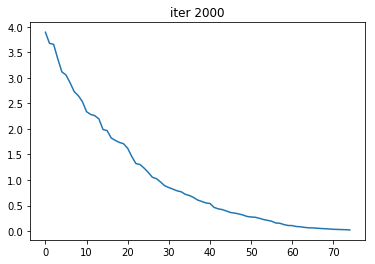

i = 4000, discriminant loss = 1.3265, generator loss =0.7274


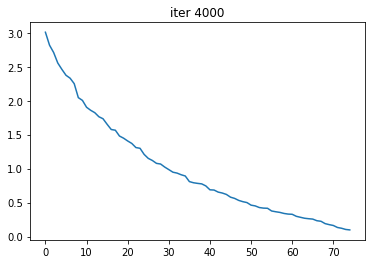

i = 6000, discriminant loss = 1.3730, generator loss =0.6980


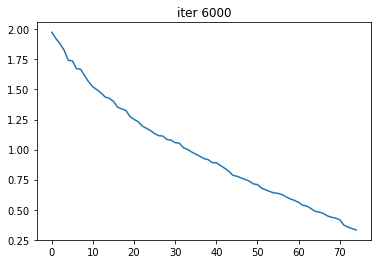

i = 8000, discriminant loss = 1.3824, generator loss =0.6947


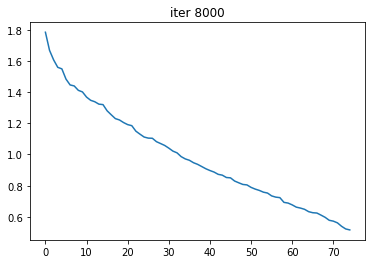

i = 10000, discriminant loss = 1.3806, generator loss =0.6989


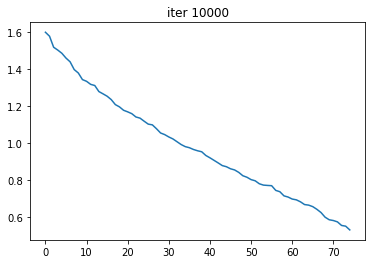

i = 12000, discriminant loss = 1.3703, generator loss =0.7037


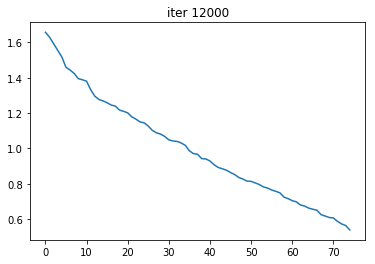

i = 14000, discriminant loss = 1.3645, generator loss =0.7058


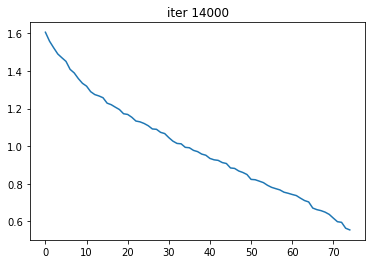

i = 16000, discriminant loss = 1.3513, generator loss =0.7180


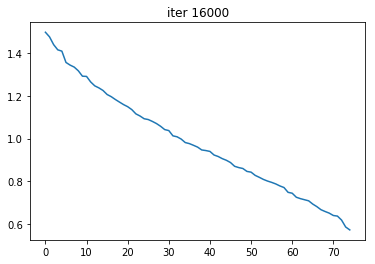

i = 18000, discriminant loss = 1.3613, generator loss =0.7066


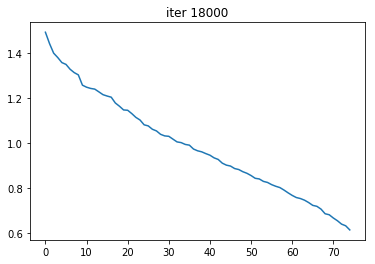

i = 20000, discriminant loss = 1.3681, generator loss =0.6979


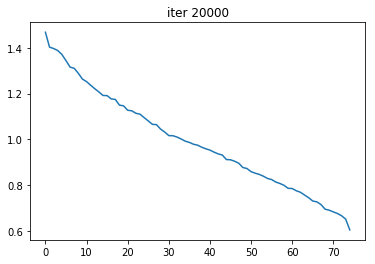

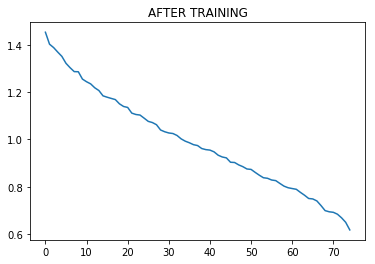

In [15]:
# Use Symplectic Gradient Adjustment to optimise the GAN parameters
high_dim_gaussian_experiment('SGA')


## Experiment 8: An SGA implementation in PyTorch


In [0]:
def list_divide_scalar(xs, y):
    return [x / y for x in xs]

def list_subtract(xs, ys):
    return [x - y for (x, y) in zip(xs, ys)]

def jacobian_vec(ys, xs, vs):
    us = [torch.zeros_like(y) + float("nan") for y in ys]
    #print(us)
    dydxs = torch.autograd.grad(ys, xs, grad_outputs=us)
    print(dydxs)
    dydxs = [torch.zeros_like(x) if dydx is None else dydx for x, dydx in zip(xs, dydxs)]
    dysdx = torch.autograd.grad(dydxs, us, grad_outputs=vs)
    return dysdx

def jacobian_transpose_vec(ys, xs, vs):
    dydxs = torch.autograd.grad(ys, xs, grad_outputs==vs)
    dydxs = [torch.zeros_like(x) if dydx is None else dydx for x, dydx in zip(xs, dydxs)]
    return dydxs

def _dot(x, y):
    return torch.mm(x, y)

In [0]:
class my_SGA(Optimizer):
    def __init__(self, params, lr=required, reg_params=1., use_signs=True, use_locking=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, reg_params=reg_params, use_signs=use_signs, 
                        use_locking=use_locking)
        super(my_SGA, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(my_SGA, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        grads = []
        vars_ = []
        for group in self.param_groups:
            for p in group['params']:
                print(p)
                grads.append(p.grad.data)
                print(p.grad.data)
                vars_.append(p.data)
        #print(grads)
        #print(vars_)
        n = len(vars_)
        h_v = jacobian_vec(grads, vars_, grads)
        ht_v = jacobian_transpose_vec(grads, vars_, grads)
        at_v = list_divide_scalar(list_subtract(ht_v, h_v), 2.)
        if group['use_signs']:
            grad_dot_h = _dot(grads, ht_v)
            at_v_dot_h = _dot(at_v, ht_v)
            mult = grad_dot_h * at_v_dot_h
            lambda_ = torch.sign(mult / n + 0.1) * group['reg_params']
        else:
            lambda_ = group['reg_params']
            
        apply_vec = [(g + lambda_ * ag, x) for (g, ag, x) in zip(grads, at_v, vars_) if at_v is not None]

        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                p.data.add_(-group['lr'], d_p)


        return loss